# Tutorial 4: Exploring unimodal data

This tutorial demonstrates a new approach for analyzing unimodal single-cell data with Ocelli. The proposed workflow uses topic modeling for finding relationships between features (topics). We treat each topic as a separate modality, consisting of features that are highly specific to a topic. Using topic-based modalities significantly reduces noise in the single-cell data.

## Pancreatic endocrinogenesis (RNA-seq)

This RNA-seq dataset consists of pancreatic developmental cells sampled from embryonic day 15.5. Data comes from [Bastidas-Ponce et al., 2019](https://journals.biologists.com/dev/article/146/12/dev173849/19483/Comprehensive-single-cell-mRNA-profiling-reveals-a). We used a count matrix available on [scVelo's website](https://scvelo.readthedocs.io/en/stable/scvelo.datasets.pancreas/#scvelo.datasets.pancreas). Our annotated matrix with filtered genes is available for download [here](LINK).

### Loading and preprocessing data

In [1]:
import anndata as ad

adata = ad.read_h5ad('pancreas.h5ad')

adata

AnnData object with n_obs × n_vars = 3696 × 5465
    obs: 'celltype'
    layers: 'spliced', 'unspliced'

Data consists of 3,696 cells and 5,465 cells. The count matrix is stored in `adata.X`.

Compute LDA topics.

In [2]:
import ocelli as oci

SEED = 17

oci.pp.LDA(adata, n_components=20, verbose=1, max_iter=50, random_state=SEED)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

Training MDM on the RNA-seq's LDA embedding would result in standard, unimodal Diffusion Maps. While such an approach is perfectly valid, LDA provides additional information - variational parameters for gene-topic association. These parameters can be interpreted as a pseudo count representing the assignment of genes to a topic. ``oci.pp.LDA`` saves these parameters to ``adata.varm['X_lda']`` as an array of shape ``(n_var, n_topics)``.

In [3]:
adata.varm['X_lda'].shape

(5465, 20)

We propose to treat topics as modalities. `oci.pp.modality_generation` looks at parameters in `adata.varm['lda']` and assigns each gene to its highest-parameter topic. Grouped genes form new modalities (their respective count matrix columns. You can control the number of genes in each modality - the default value is at most 100. If you set `norm_log=True` in `oci.pp.modality_generation`, new modalities get normalized and logarithmized.

In [4]:
oci.pp.modality_generation(adata, norm_log=True, verbose=True)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


[modality0]	Modality generated.
[modality1]	Modality generated.
[modality2]	Modality generated.
[modality3]	Modality generated.
[modality4]	Modality generated.
[modality5]	Modality generated.
[modality6]	Modality generated.
[modality7]	Modality generated.
[modality8]	Modality generated.
[modality9]	Modality generated.
[modality10]	Modality generated.
[modality11]	Modality generated.
[modality12]	Modality generated.
[modality13]	Modality generated.
[modality14]	Modality generated.
[modality15]	Modality generated.
[modality16]	Modality generated.
[modality17]	Modality generated.
[modality18]	Modality generated.
[modality19]	Modality generated.
20 topic-based modalities generated.


``oci.pp.modality_generation`` automatically saves generated modality names to ``adata.uns['modalities']``.

In [5]:
adata.uns['modalities']

['modality0',
 'modality1',
 'modality2',
 'modality3',
 'modality4',
 'modality5',
 'modality6',
 'modality7',
 'modality8',
 'modality9',
 'modality10',
 'modality11',
 'modality12',
 'modality13',
 'modality14',
 'modality15',
 'modality16',
 'modality17',
 'modality18',
 'modality19']

`adata` includes unspliced and spliced gene expression layers. Therefore, you can use RNA velocity when visualizing the dataset.

Calculate velocities on 1,000 normalized and logarithmized highly variable genes. 

In [7]:
import scvelo as scv

scv.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(adata, n_top_genes=1000)
scv.pp.log1p(adata)

scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Multimodal Diffusion Maps

Modalities with normalized and logarithmized topic-specific gene counts are ready for the MDM training. We use LDA's cell-topic distributions as weights. These distributions can be interpreted as the assignment of topics to cells. In other words, a cell's MDM representation is based only on genes specific to topics assigned to a cell. The significant advantage of such an approach is that for each expression space region (topic), you utilize only relevant region-specific (topic-specific) genes. This step significantly reduces noise existing in single-cell data.

``oci.pp.modality_generation`` saves LDA-based weights to ``adata.obsm['lda_weights']``.

In [8]:
adata.obsm['weights']

,modality0,modality1,modality2,modality3,modality4,modality5,modality6,modality7,modality8,modality9,modality10,modality11,modality12,modality13,modality14,modality15,modality16,modality17,modality18,modality19
AAACCTGAGAGGGATA,0.002430,0.007674,0.007712,0.102145,0.002342,0.008317,0.001827,0.017973,0.007638,0.063900,0.049555,0.042434,0.094664,0.024815,0.079300,0.009830,0.371567,0.043714,0.020644,0.041521
AAACCTGAGCCTTGAT,0.001912,0.278708,0.002602,0.087956,0.001166,0.012176,0.001074,0.104506,0.012574,0.006301,0.026456,0.004610,0.243986,0.020106,0.000990,0.132102,0.003261,0.005555,0.032054,0.021906
AAACCTGAGGCAATTA,0.003665,0.012536,0.014184,0.013503,0.002706,0.020714,0.027890,0.077708,0.015388,0.063211,0.071690,0.151815,0.131225,0.030949,0.011694,0.034146,0.243392,0.008848,0.016192,0.048543
AAACCTGCATCATCCC,0.001046,0.118428,0.002715,0.029078,0.001066,0.012884,0.000936,0.110373,0.087123,0.003526,0.058260,0.003513,0.121219,0.007089,0.000843,0.418786,0.002353,0.003590,0.012426,0.004745
AAACCTGGTAAGTGGC,0.001827,0.010498,0.011332,0.030509,0.001866,0.085311,0.001635,0.018233,0.009816,0.182690,0.056825,0.012112,0.048607,0.120583,0.002015,0.012569,0.036090,0.297624,0.054869,0.004990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTGACATA,0.001140,0.006241,0.021874,0.041146,0.001111,0.009308,0.001104,0.057680,0.013975,0.166825,0.046281,0.067421,0.092043,0.092049,0.000877,0.008964,0.200480,0.118638,0.042896,0.009948
TTTGTCAAGTGTGGCA,0.001294,0.002969,0.003524,0.102868,0.001158,0.113681,0.001086,0.025608,0.007960,0.009393,0.034449,0.004601,0.035406,0.106191,0.000895,0.118450,0.004743,0.262046,0.156797,0.006881
TTTGTCAGTTGTTTGG,0.002135,0.405979,0.002980,0.081686,0.001517,0.039509,0.001331,0.144264,0.009441,0.008396,0.067988,0.004884,0.069425,0.016991,0.001272,0.090794,0.003418,0.006730,0.022281,0.018983
TTTGTCATCGAATGCT,0.001022,0.002333,0.002794,0.117173,0.315331,0.025995,0.044490,0.095125,0.007444,0.020210,0.007918,0.129767,0.056801,0.009333,0.016400,0.022803,0.005755,0.028691,0.008228,0.082386


Calculate the MDM representation.

In [9]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.MDM(adata, n_components=25, random_state=SEED, verbose=True)

[modality0]	20 nearest neighbors calculated.
[modality1]	20 nearest neighbors calculated.
[modality2]	20 nearest neighbors calculated.
[modality3]	20 nearest neighbors calculated.
[modality4]	20 nearest neighbors calculated.
[modality5]	20 nearest neighbors calculated.
[modality6]	20 nearest neighbors calculated.
[modality7]	20 nearest neighbors calculated.
[modality8]	20 nearest neighbors calculated.
[modality9]	20 nearest neighbors calculated.
[modality10]	20 nearest neighbors calculated.
[modality11]	20 nearest neighbors calculated.
[modality12]	20 nearest neighbors calculated.
[modality13]	20 nearest neighbors calculated.
[modality14]	20 nearest neighbors calculated.
[modality15]	20 nearest neighbors calculated.
[modality16]	20 nearest neighbors calculated.
[modality17]	20 nearest neighbors calculated.
[modality18]	20 nearest neighbors calculated.
[modality19]	20 nearest neighbors calculated.


2023-01-24 18:15:35,023	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
[modality2]	Unimodal Markov chain calculated.
[modality3]	Unimodal Markov chain calculated.
[modality4]	Unimodal Markov chain calculated.
[modality5]	Unimodal Markov chain calculated.
[modality6]	Unimodal Markov chain calculated.
[modality7]	Unimodal Markov chain calculated.
[modality8]	Unimodal Markov chain calculated.
[modality9]	Unimodal Markov chain calculated.
[modality10]	Unimodal Markov chain calculated.
[modality11]	Unimodal Markov chain calculated.
[modality12]	Unimodal Markov chain calculated.
[modality13]	Unimodal Markov chain calculated.
[modality14]	Unimodal Markov chain calculated.
[modality15]	Unimodal Markov chain calculated.
[modality16]	Unimodal Markov chain calculated.
[modality17]	Unimodal Markov chain calculated.
[modality18]	Unimodal Markov chain calculated.
[modality19]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
25 Mu

### Visualizing MDM components

Calculate the ForceAtlas2 representation of the MDM embedding's RNA velocity-based graph.

In [10]:
oci.pp.neighbors(adata, x=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.transitions_graph(adata, x='X_mdm', transitions='velocity_graph', n_edges=20, verbose=True)

[X_mdm]	100 nearest neighbors calculated.
Transitions-based graph constructed.


In [11]:
oci.tl.FA2(adata, n_components=2, random_state=SEED)

Jan 24, 2023 6:15:58 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Jan 24, 2023 6:15:59 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 3,696 (3,696 added)
Jan 24, 2023 6:15:59 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 73,920 (70,815 added)


*************************25%
*************************50%
*************************75%
***************

**********100%
Time = 32.392s


Plot the 2D embedding with the annotations prepared by the dataset authors (stored in ``adata.obs['clusters']``). 

In [37]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

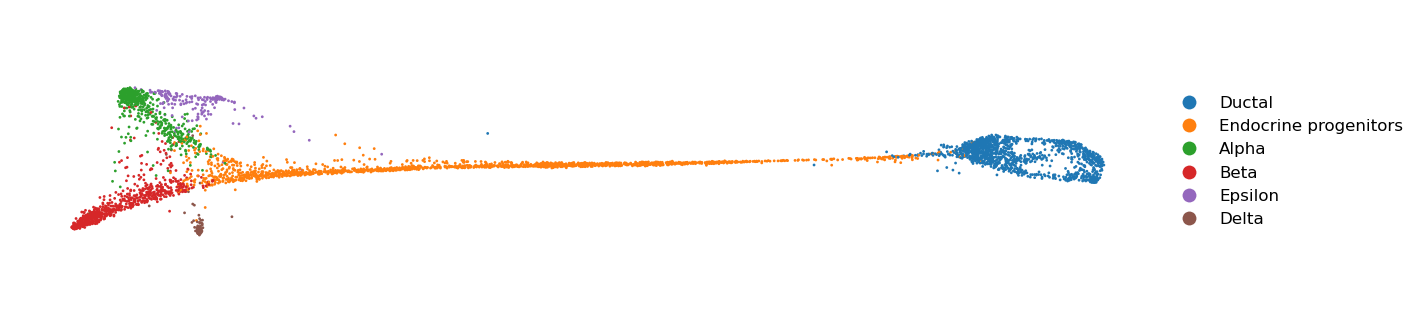

In [38]:
cdict = {'Ductal': '#1f77b4',
         'Endocrine progenitors': '#ff7f0e', 
         'Alpha': '#2ca02c', 
         'Beta': '#d62728', 
         'Epsilon': '#9467bd', 
         'Delta': '#8c564b'}

oci.pl.scatter(adata, x='X_fa2', c='celltype', cdict=cdict, markersize=1, title='', fontsize=6, figsize=(7, 1.5))

Each LDA topic relates to a different region of the single-cell expression space. You can investigate these regions by plotting topic activity (cell-topic distributions).

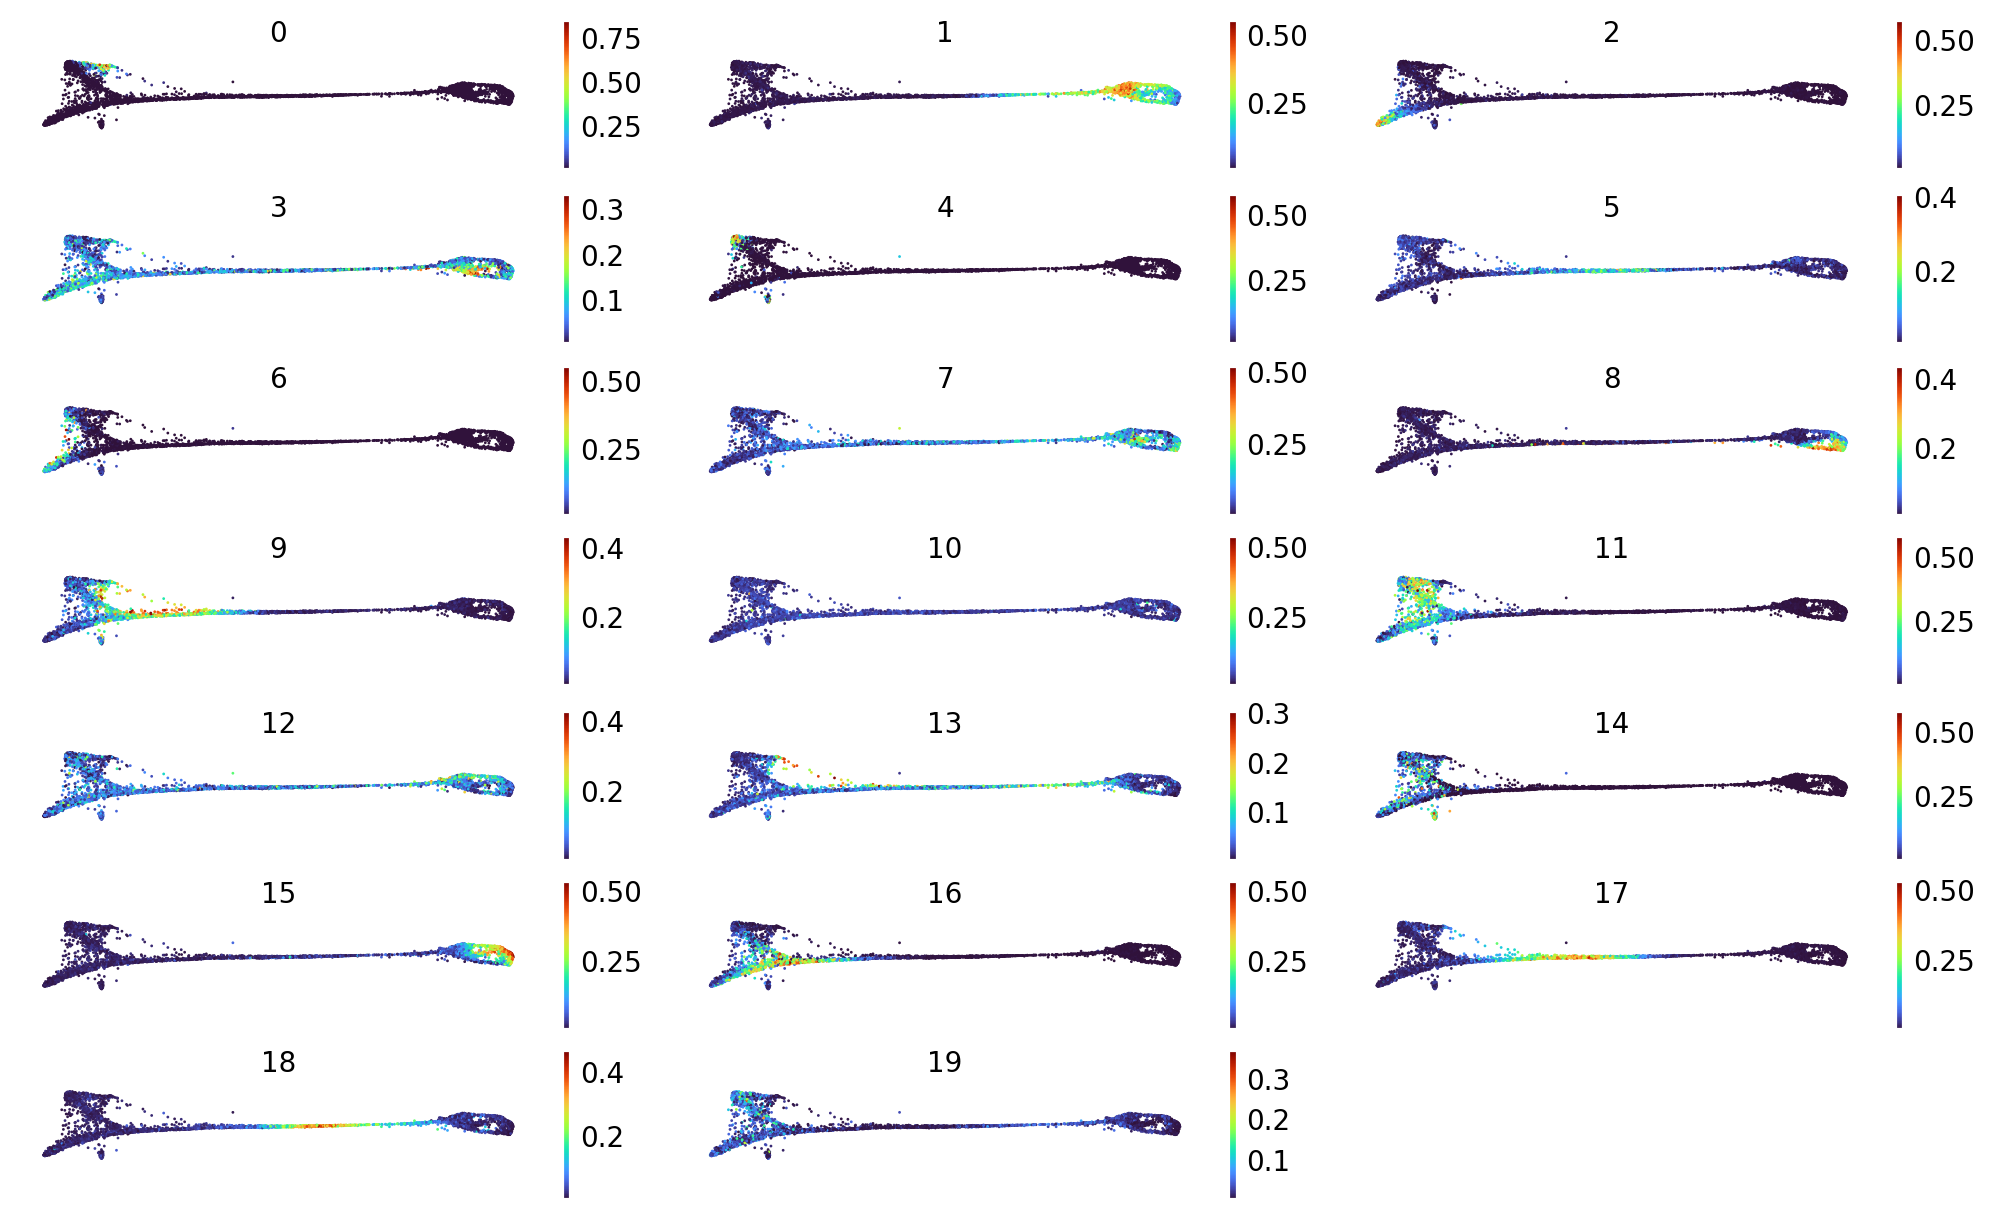

In [39]:
oci.pl.scatter(adata, x='X_fa2', c='X_lda', cmap='turbo', markersize=1, figsize=(10, 6), fontsize=10, ncols=3, markerscale=2)

Two significant regions split the developmental process: proliferative Ductal cells, and endocrine lineages.

### Reconstructing the cell cycle of Ductal cells

Firstly, investigate the cell cycle of proliferative Ductal cells.

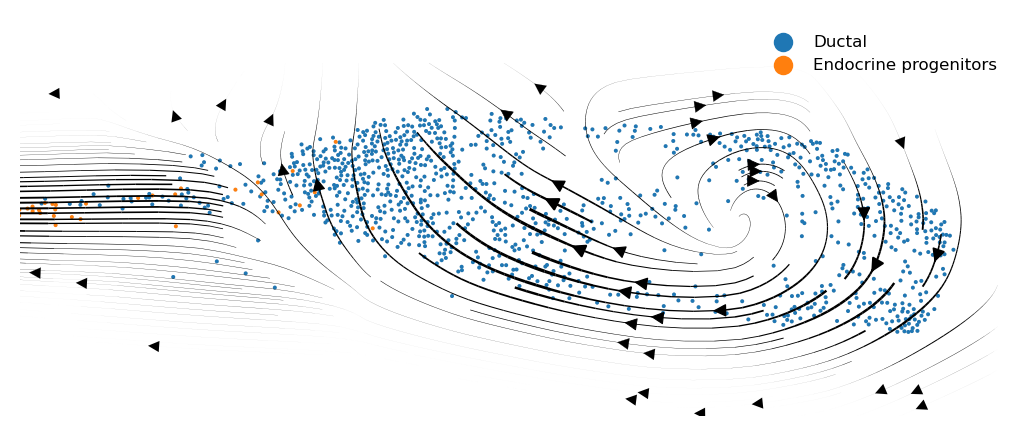

In [47]:
fig, ax = mpl.pyplot.subplots()

scv.pl.velocity_embedding_stream(adata, basis='fa2', alpha=1, title='', density=4, xlim=[9500, 14000], ylim=[-900, 900], 
                                 linewidth=1, legend_fontsize=6, size=8, legend_loc='best', groups=['Ductal', 'Endocrine progenitors'], show=False, ax=ax,
                                 color='celltype', palette=cdict, cutoff_perc=0)

ax.set_aspect('equal')

You can validate the velocity stream by plotting scores for:

- S (DNA replication) cell cycle phase,
- combined G2 (preparation for mitosis) and M (cell division) cell cycle phases.

Arrows should go from high S-scoring cells towards high G2M-scoring cells.

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


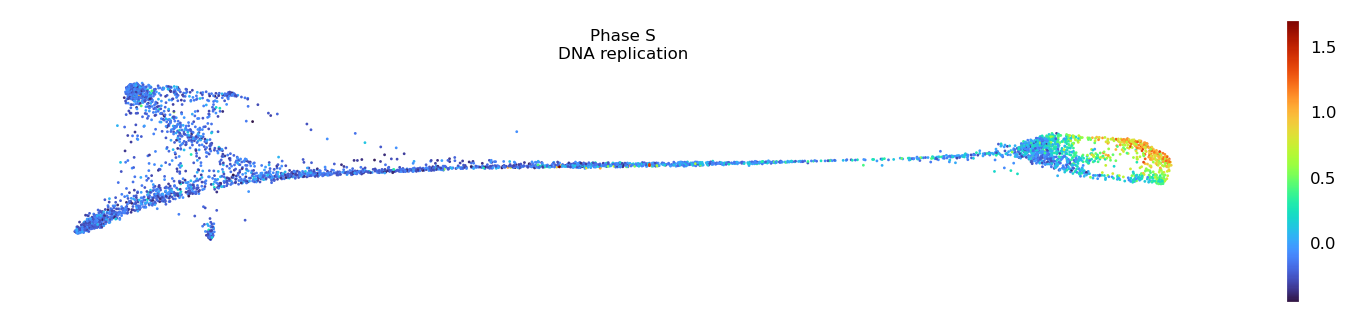

In [41]:
scv.tl.score_genes_cell_cycle(adata)

oci.pl.scatter(adata, x='X_fa2', c='S_score', cmap='turbo', title='Phase S\nDNA replication', markersize=1, figsize=(7, 1.5))

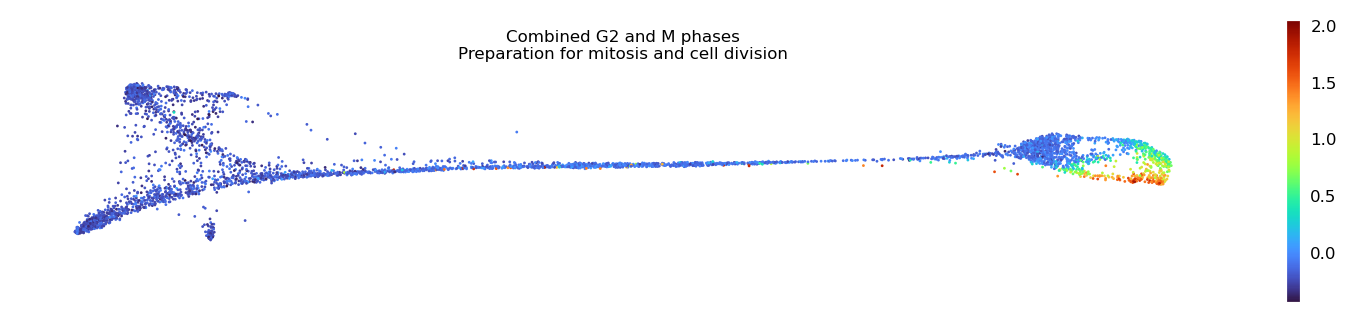

In [42]:
oci.pl.scatter(adata, x='X_fa2', c='G2M_score', cmap='turbo', 
               title='Combined G2 and M phases\nPreparation for mitosis and cell division', 
               markersize=1, figsize=(7, 1.5))

### Tracing the development of endocrine cells

Endocrine cells are derived from endocrine progenitors and form four significant lineages (studied in detail [here](https://www.nature.com/articles/s41422-021-00486-w)):

- Glucagon-producing Alpha cells,
- Insulin-producing Beta cells,
- Somatostatin-producing Delta cells,
- Ghrelin-producing Epsilon cells.

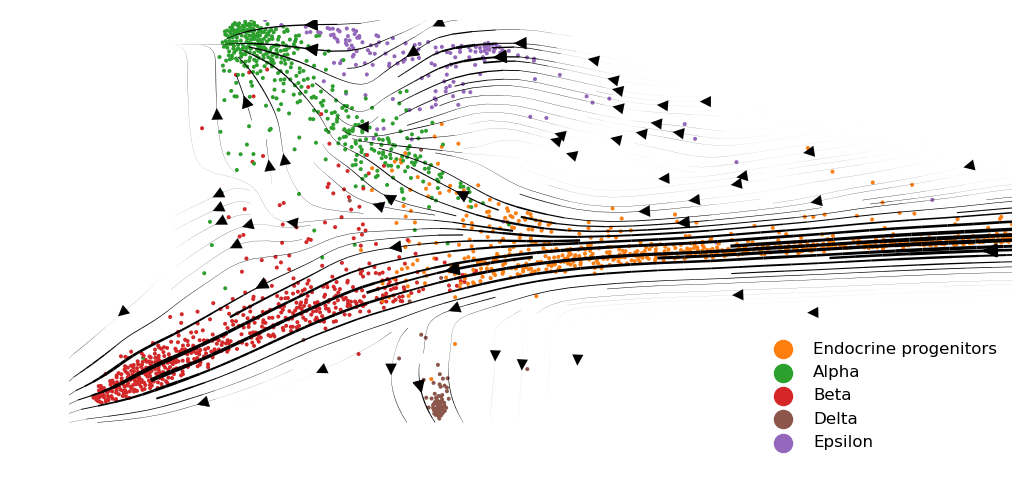

In [48]:
celltypes = ['Endocrine progenitors', 'Alpha', 'Beta', 'Delta', 'Epsilon']

fig, ax = mpl.pyplot.subplots()

scv.pl.velocity_embedding_stream(adata, basis='fa2', alpha=1, title='', density=3, legend_fontsize=6, xlim=[-8800, -1000], ylim=[-2000, 1500], 
                                 linewidth=1., size=8, legend_loc='best', groups=celltypes, show=False, ax=ax,
                                 color='celltype', palette=cdict, cutoff_perc=0)

ax.set_aspect('equal')

## iPSCs reprogramming (RNA-seq)

The second half of this tutorial shows the analysis of cellular reprogramming. Cell reprogramming is a complex biological process aiming to convert cells to induced pluripotent stem cells (iPSC) before differentiation into diverse cell types.

The data comes from [Schiebinger, Geoffrey, et al. "Optimal-transport analysis of single-cell gene expression identifies developmental trajectories in reprogramming." Cell 176.4 (2019): 928-943.](https://www.sciencedirect.com/science/article/pii/S009286741930039X). The authors obtained Mouse Embryonic Fibroblasts (MEFs) from a single female embryo. They plated MEFs in serum, added Dox on day 0, withdrew Dox on day 8, and transferred cells to either serum-free N2B27 2i medium or maintained them in serum. Hence experiment can be split into Phase 1 (Dox) and Phase 2 (two separate conditions: 2i or serum). Phase 2 lasted till day 18. Here, we explore Phase 2's cells in serum condition, looking for the clear ancestor trajectory of day 18 iPSCs. Authors of the dataset found such a trajectory for cells in the 2i condition but not in the serum condition.

Load the necessary packages.

In [1]:
import anndata
from os.path import join
import pandas as pd
import scanpy as sc
import ocelli as oci
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

SEED = 17

# a path to the folder with data
folder_path = '../../../../experiments/reprogramming/data'

### Load and preprocess the data

During data preparation, we ran the [Velocyto](http://velocyto.org) on [raw bam files](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115943) (we run analyses on gene expression spliced layer). Then, we concatenated the resulting loom files into a single h5ad file and calculated doublet scores using [Scrublet](https://github.com/swolock/scrublet). 

Load the resulting h5ad file.

In [2]:
%%time

adata = anndata.read_h5ad(join(folder_path, 'reprogramming_doublet.h5ad'))

adata

CPU times: user 2.79 s, sys: 6.67 s, total: 9.46 s
Wall time: 9.45 s


AnnData object with n_obs × n_vars = 251203 × 27998
    obs: 'origin', 'barcode', 'velocyto_barcode', 'doublet_score', 'predicted_doublet'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

The whole dataset consists  of 251,203 cells and 27998 genes.

Clean up ``adata.obs``.

In [3]:
df_obs = pd.DataFrame(index=list(adata.obs.index))
df_obs['timestamp'] = [el.split('_')[0][1:] for el in adata.obs['origin']]
df_obs['origin'] = [el.split('_')[1] for el in adata.obs['origin']]
df_obs['doublet_score'] = list(adata.obs['doublet_score'])

adata.obs = df_obs

adata.obs

,timestamp,origin,doublet_score
D0.5_Dox_C2_AACGTTGAGTGGACGT-1,0.5,Dox,0.109677
D0.5_Dox_C2_AACTGGTGTAGAGTGC-1,0.5,Dox,0.179331
D0.5_Dox_C2_AAATGCCTCTCAAGTG-1,0.5,Dox,0.192308
D0.5_Dox_C2_AACTCCCAGTCAAGCG-1,0.5,Dox,0.103734
D0.5_Dox_C2_AACTTTCCATGTCGAT-1,0.5,Dox,0.286344
...,...,...,...
DiPSC_serum_C2_TTTATGCCAGCTGTAT-1,iPSC,serum,0.126516
DiPSC_serum_C2_TTTCCTCCAAGAGTCG-1,iPSC,serum,0.121212
DiPSC_serum_C2_TTTCCTCGTTGGTTTG-1,iPSC,serum,0.121212
DiPSC_serum_C2_TTTGTCATCTTCGGTC-1,iPSC,serum,0.026253


Load a gene list for ``adata.var``.

In [4]:
df_var = pd.read_csv(join(folder_path, 'var-genes.csv'), names=['gene'], index_col='gene', header=0)

adata.var = df_var

adata.var

""
gene
Xkr4
Gm37381
Rp1
Rp1-1
Sox17
...
Gm28672
Gm28670
Gm29504


We focus on cells in serum condition.

In [5]:
adata = adata[adata.obs['origin'].isin(['Dox', 'serum']), :]

Remove cells with doublet score above 0.3. The doublet score histogram is plotten below.

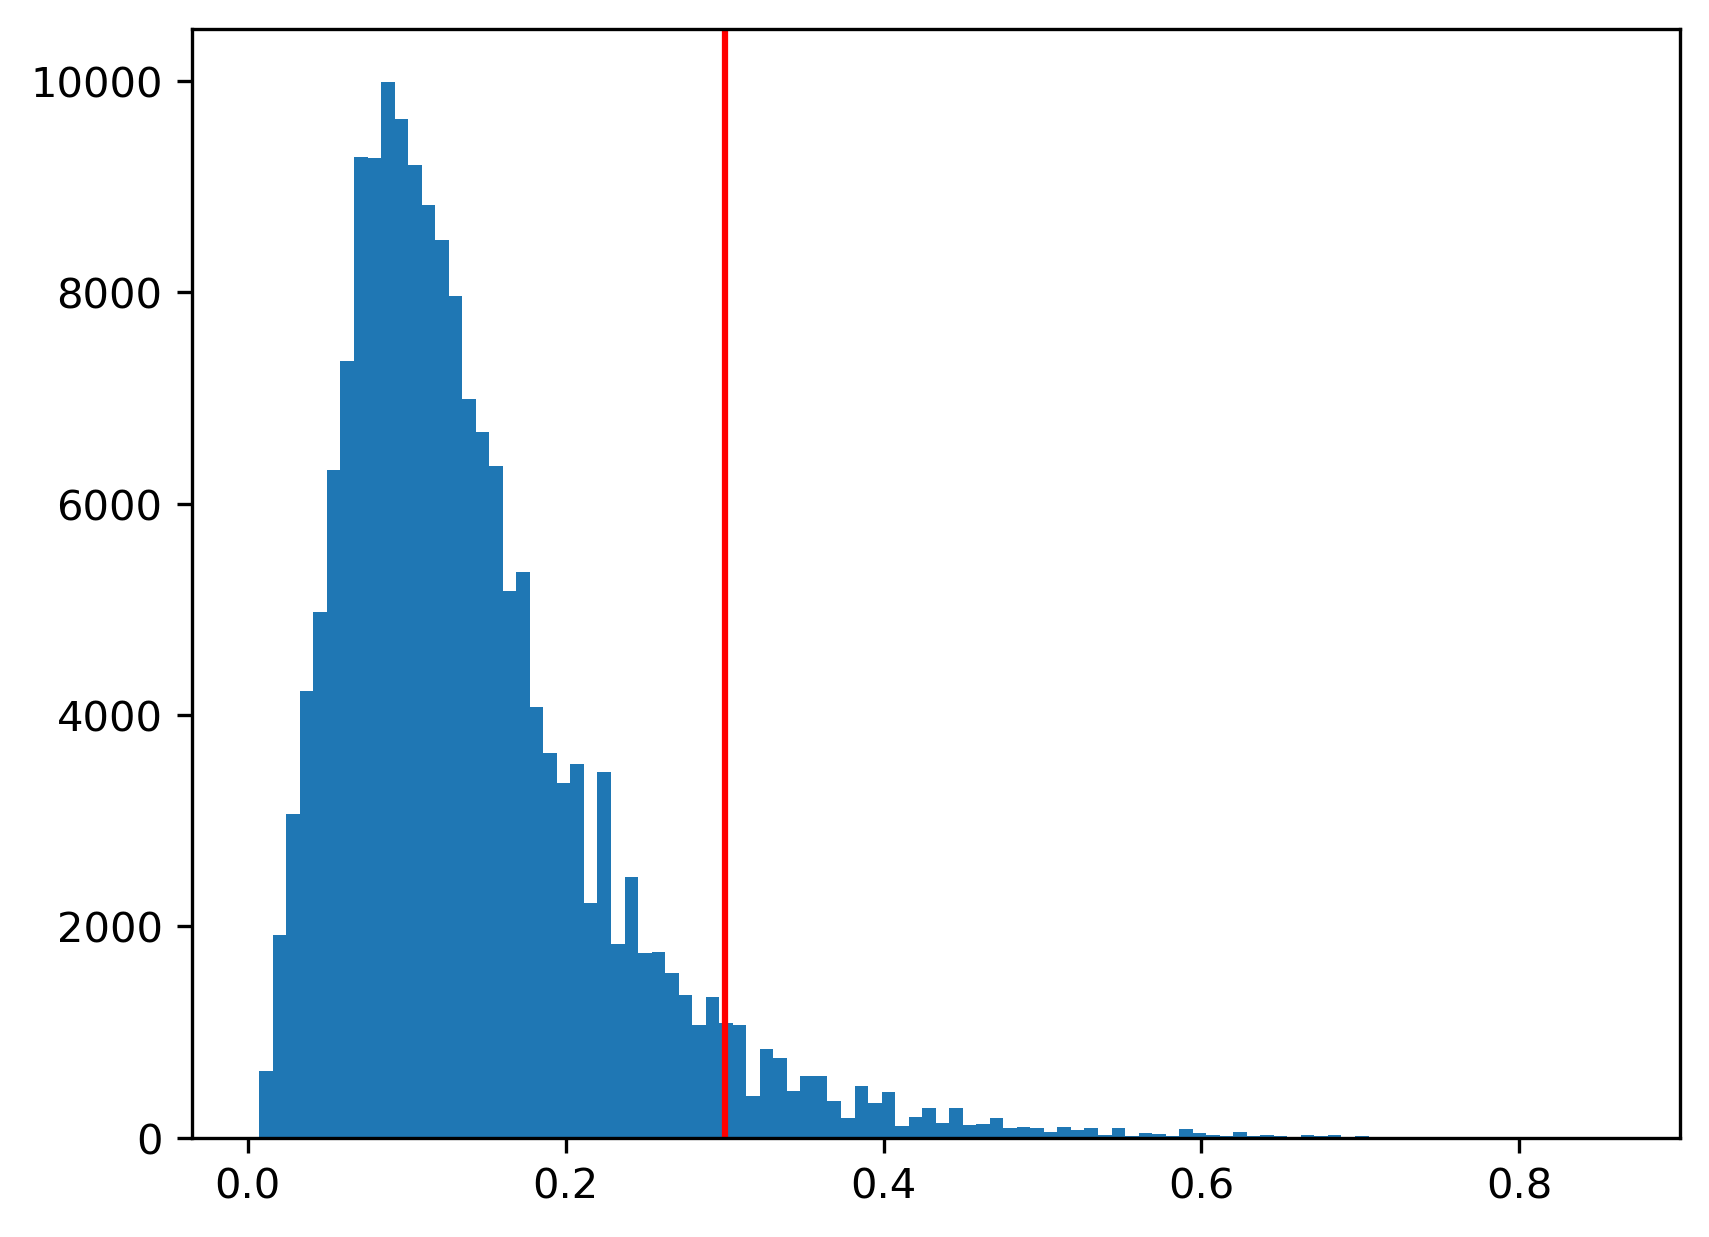

In [6]:
fig, ax = plt.subplots()
ax.hist(adata.obs['doublet_score'], 100)
ax.axvline(0.3, c='red')

adata = adata[adata.obs['doublet_score'] < 0.3]

Keep cells between days 8 and 18.

In [7]:
filtered_timestamps = ['8', '8.25', '8.5', '8.75', '9', '9.5',  
                       '10', '10.5', '11', '11.5', '12', '12.5',
                       '13', '13.5', '14', '14.5', '15', '15.5',
                       '16', '16.5', '17', '17.5', '18']

adata = adata[adata.obs['timestamp'].isin(filtered_timestamps), :]

adata.obs['timestamp_float'] = [float(t) for t in adata.obs['timestamp']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


Preprocess the count matrix as the dataset authors:

- remove cells with less than 2000 UMIs,
- remove genes expressed in less than 50 cells,
- if cell's UMI count is greater than 15,000, donwsample it to 15,000 UMIs.

In [8]:
sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.downsample_counts(adata, counts_per_cell=15000, random_state=SEED)

In [ ]:
adata.write('reprogramming-raw.h5ad', compression='gzip', compression_opts=9)

The filtered AnnData consists of 68703 cells and 16817 genes.

In [2]:
import anndata as ad
adata = ad.read_h5ad('reprogramming-raw.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 68703 × 16817
    obs: 'timestamp', 'origin', 'doublet_score', 'timestamp_float', 'n_counts'
    var: 'n_cells'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Generate topic-based modalities.

In [ ]:
oci.pp.LDA(adata, n_components=20, output_key='lda', verbose=2, max_iter=30, random_state=SEED)
oci.pp.modality_generation(adata, topic_key='lda', norm_log=True, verbose=True)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   43.6s remaining:  5.1min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   54.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 1 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   42.1s remaining:  4.9min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   51.2s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 2 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   41.7s remaining:  4.9min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   51.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 3 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   39.9s remaining:  4.7min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   51.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 4 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   37.6s remaining:  4.4min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   49.1s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 5 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   40.4s remaining:  4.7min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   47.3s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 6 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   41.2s remaining:  4.8min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   51.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 7 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   42.4s remaining:  4.9min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   51.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 8 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   42.8s remaining:  5.0min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   51.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 9 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   42.7s remaining:  5.0min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   50.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 10 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   39.4s remaining:  4.6min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   49.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 11 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   38.1s remaining:  4.4min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   46.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 12 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   42.4s remaining:  4.9min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   51.9s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 13 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   42.3s remaining:  4.9min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   52.3s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 14 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   42.0s remaining:  4.9min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   52.3s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 15 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   44.0s remaining:  5.1min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   51.3s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 16 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   37.7s remaining:  4.4min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   52.2s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 17 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   37.0s remaining:  4.3min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   49.0s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 18 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   38.2s remaining:  4.5min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   48.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 19 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   41.3s remaining:  4.8min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   51.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


iteration: 20 of max_iter: 30


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   41.9s remaining:  4.9min


In [ ]:
adata.write('reprogramming-raw.h5ad', compression='gzip', compression_opts=9)

### Waddington Optimal Transport

Ocelli can use cellular transition probabilities calculated using any algorithm. Here, we use [Waddington Optimal Transport](https://www.sciencedirect.com/science/article/pii/S009286741930039X) precomputed transitions, which you can download [here](https://broadinstitute.github.io/wot/tutorial/) from the *transport maps* tutorial. The tutorial contains h5ad files with transitions between consecutive timestamps. In the code below we combine all transitions into a single csr_matrix and save it in ``adata.uns['optimal_transport']``.

In [2]:
import anndata as ad
adata = ad.read_h5ad('reprogramming-raw.h5ad')

In [3]:
import numpy as np
from scipy.sparse import coo_matrix
from tqdm import tqdm

# clear adata.X and adata.layers co that adata object uses less memory
# modalities are already saved in adata.obsm
adata.X = csr_matrix(([], ([], [])), shape=adata.shape)
adata.layers = {}

paths = ['serum_8.0_8.25.h5ad', 'serum_8.25_8.5.h5ad',  'serum_8.5_8.75.h5ad', 
         'serum_8.75_9.0.h5ad', 'serum_9.0_9.5.h5ad', 'serum_9.5_10.0.h5ad', 
         'serum_10.0_10.5.h5ad', 'serum_10.5_11.0.h5ad', 'serum_11.0_11.5.h5ad', 
         'serum_11.5_12.0.h5ad', 'serum_12.0_12.5.h5ad', 'serum_12.5_13.0.h5ad', 
         'serum_13.0_13.5.h5ad', 'serum_13.5_14.0.h5ad', 'serum_14.0_14.5.h5ad', 
         'serum_14.5_15.0.h5ad', 'serum_15.0_15.5.h5ad', 'serum_15.5_16.0.h5ad', 
         'serum_16.0_16.5.h5ad', 'serum_16.5_17.0.h5ad', 'serum_17.0_17.5.h5ad', 
         'serum_17.5_18.0.h5ad']

def filter_cells(adata, x):
    obs_in, var_in = list(), list()
    
    for el in adata.obs.index:
        if el in x.obs.index:
            obs_in.append(el)
    for el in adata.obs.index:
        if el in x.var.index:
            var_in.append(el)
            
    return x[obs_in, var_in]
        
barcode_map = dict()
for i, barcode in enumerate(adata.obs.index):
    barcode_map[barcode] = i
    
M = coo_matrix(([], ([], [])), shape=(adata.shape[0], adata.shape[0])).tocsr()
    
for path in tqdm(paths):
    x = anndata.read_h5ad(join(folder_path, 'tmaps/{}'.format(path)))    
    x = filter_cells(adata, x)
    
    obs = [barcode_map[el] for el in x.obs.index]
    var = [barcode_map[el] for el in x.var.index]
    
    M[np.ix_(obs, var)] = csr_matrix(x.X)

adata.uns['optimal_transport'] = M

  0%|          | 0/22 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|██████████| 22/22 [02:07<00:00,  5.79s/it]


### Multimodal Diffusion Maps

Calculate the MDM components using LDA-based weights.

In [4]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.MDM(adata, weights_key='lda_weights', n_components=20, random_state=SEED, verbose=True, save_mmc=True)

[modality0]	20 nearest neighbors calculated.
[modality1]	20 nearest neighbors calculated.
[modality2]	20 nearest neighbors calculated.
[modality3]	20 nearest neighbors calculated.
[modality4]	20 nearest neighbors calculated.
[modality5]	20 nearest neighbors calculated.
[modality6]	20 nearest neighbors calculated.
[modality7]	20 nearest neighbors calculated.
[modality8]	20 nearest neighbors calculated.
[modality9]	20 nearest neighbors calculated.
[modality10]	20 nearest neighbors calculated.
[modality11]	20 nearest neighbors calculated.
[modality12]	20 nearest neighbors calculated.
[modality13]	20 nearest neighbors calculated.
[modality14]	20 nearest neighbors calculated.
[modality15]	20 nearest neighbors calculated.
[modality16]	20 nearest neighbors calculated.
[modality17]	20 nearest neighbors calculated.
[modality18]	20 nearest neighbors calculated.
[modality19]	20 nearest neighbors calculated.


2023-01-17 13:01:18,262	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
[modality2]	Unimodal Markov chain calculated.
[modality3]	Unimodal Markov chain calculated.
[modality4]	Unimodal Markov chain calculated.
[modality5]	Unimodal Markov chain calculated.
[modality6]	Unimodal Markov chain calculated.
[modality7]	Unimodal Markov chain calculated.
[modality8]	Unimodal Markov chain calculated.
[modality9]	Unimodal Markov chain calculated.
[modality10]	Unimodal Markov chain calculated.
[modality11]	Unimodal Markov chain calculated.
[modality12]	Unimodal Markov chain calculated.
[modality13]	Unimodal Markov chain calculated.
[modality14]	Unimodal Markov chain calculated.
[modality15]	Unimodal Markov chain calculated.
[modality16]	Unimodal Markov chain calculated.
[modality17]	Unimodal Markov chain calculated.
[modality18]	Unimodal Markov chain calculated.
[modality19]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
20 Mu

In [5]:
adata.write('reprogramming-MDM.h5ad', compression='gzip', compression_opts=9)

Generate a 3D ForceAtlas2 embedding. ``oci.tl.timestamp_graph`` produces a graph similar to ``oci.tl.velocity_graph``, but uses additional information from timestamps. You can find details in the API.

In [6]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.timestamp_graph(adata, 
                       transitions_key='optimal_transport', 
                       timestamps_key='timestamp_float', 
                       n_edges=10,
                       neighbors_key='X_mdm', 
                       verbose=True)

oci.tl.FA2(adata, n_components=3, n_iter=15000, random_state=SEED, output_key='X_fa2')

[X_mdm]	100 nearest neighbors calculated.


23it [01:00,  2.64s/it]


Timestamp-based graph constructed.


Jan 17, 2023 1:52:04 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Jan 17, 2023 1:52:07 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 68,703 (68,703 added)
Jan 17, 2023 1:52:07 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 687,030 (607,465 added)


*

************************25%
*************************50%
*************************75%
*************************100%
Time = 2176.597s


To create an interactive 3D scatter plot in html, use the code below. Generated plot is available for download [here](https://github.com/TabakaLab/ocelli/tree/dev/html/ipsc_reprogramming).

In [13]:
adata.write('reprogramming-FLE.h5ad', compression='gzip', compression_opts=9)

In [4]:
import anndata as ad
adata = ad.read_h5ad('reprogramming-FLE.h5ad')

In [7]:
oci.pl.scatter_interactive(adata, x='X_fa2', c='timestamp_float', ccontinuous='jet', save='figures/reprogramming_3d.html')

To generate 2D projection plots, run the following.

In [19]:
oci.pl.projections(adata, x='X_fa2', markersize=0.05, c='timestamp_float', cmap='viridis', figsize=(13, 8), save='figures/reprogramming_projections.png')

MDM successfully reconstructed a clear ancestor trajectory of day 18 iPSCs for cells in serum condition. This is a thin string connecting day 18 iPSCs and day 10 cells, coming out of the spike on the left side of the plot. The biology behind this string is described [here](https://www.sciencedirect.com/science/article/pii/S009286741930039X).

In [31]:
oci.tl.projection(adata, x='X_fa2', phi=230, theta=65)
oci.pl.scatter(adata, x='X_proj', c='timestamp_float', cmap='viridis', save='figures/reprogramming_projection.png')

Finally, investigate the topic quality.

In [32]:
oci.pl.scatter(adata, x='X_proj', c='lda', cmap='turbo', markersize=0.05, vmin=0, ncols=5, figsize=(10, 6), save='figures/reprogramming_topics.png')

Congratulations! Now you can easily use Ocelli for your single-cell analyses. Good luck!

In [45]:
oci.tl.louvain(adata, x='X_mdm', n_neighbors=20, resolution=0.4, random_state=SEED)

In [71]:
colors = np.asarray(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                     '#8c564b', '#e377c2', '#bcbd22', '#17becf', '#B3C6E5', 
                     '#F5BE82','#A7DD93', '#F19D99', '#C1B1D2', '#BE9D96'])
louvain_mapping = {str(i): colors[i] for i in range(np.unique(adata.obs.louvain).shape[0])}

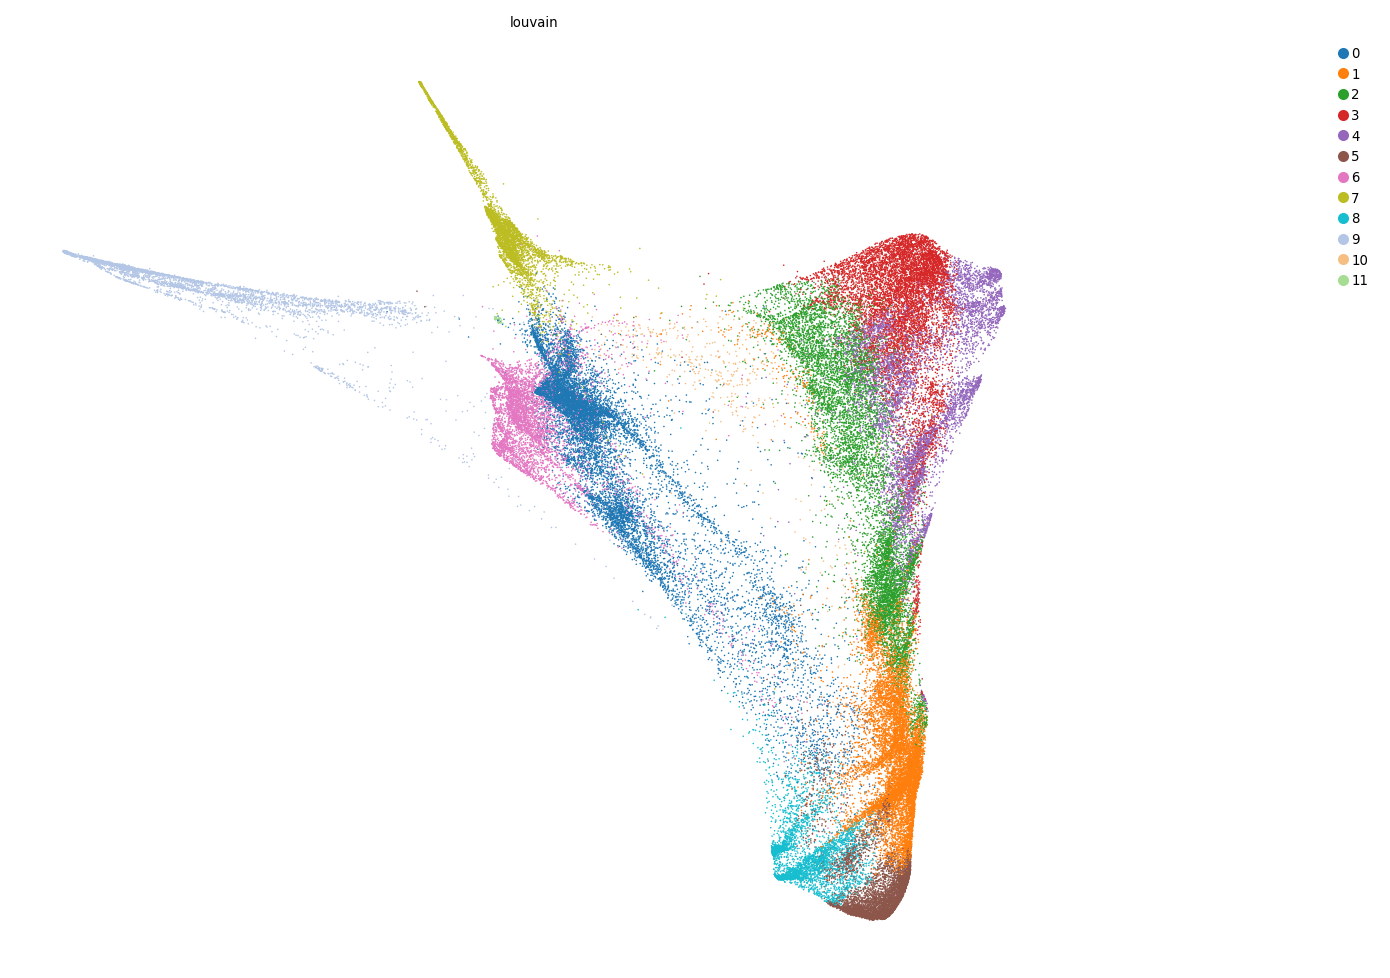

In [72]:
oci.pl.scatter(adata, x='X_proj', c='louvain', cdict=louvain_mapping, markersize=0.5, vmin=0, ncols=5, figsize=(10, 6))

In [73]:
oci.pl.projections(adata, x='X_fa2', markersize=0.05, c='louvain', cdict=louvain_mapping, figsize=(13, 8), save='figures/reprogramming_projections_louvain.png')

In [74]:
oci.pl.scatter_interactive(adata, x='X_fa2', c='louvain', cdiscrete=louvain_mapping, save='figures/reprogramming_3d_louvain.html')

In [68]:
import numpy as np
import pandas as pd

adata_deg = ad.read_h5ad('reprogramming-raw.h5ad')
adata_deg.obs['louvain'] = list(adata.obs.louvain)
sc.pp.normalize_total(adata_deg, target_sum=10000)
sc.pp.log1p(adata_deg)

sc.tl.rank_genes_groups(adata_deg, groupby='louvain', method='wilcoxon')
adata_deg.layers['scaled'] = sc.pp.scale(adata_deg, copy=True).X

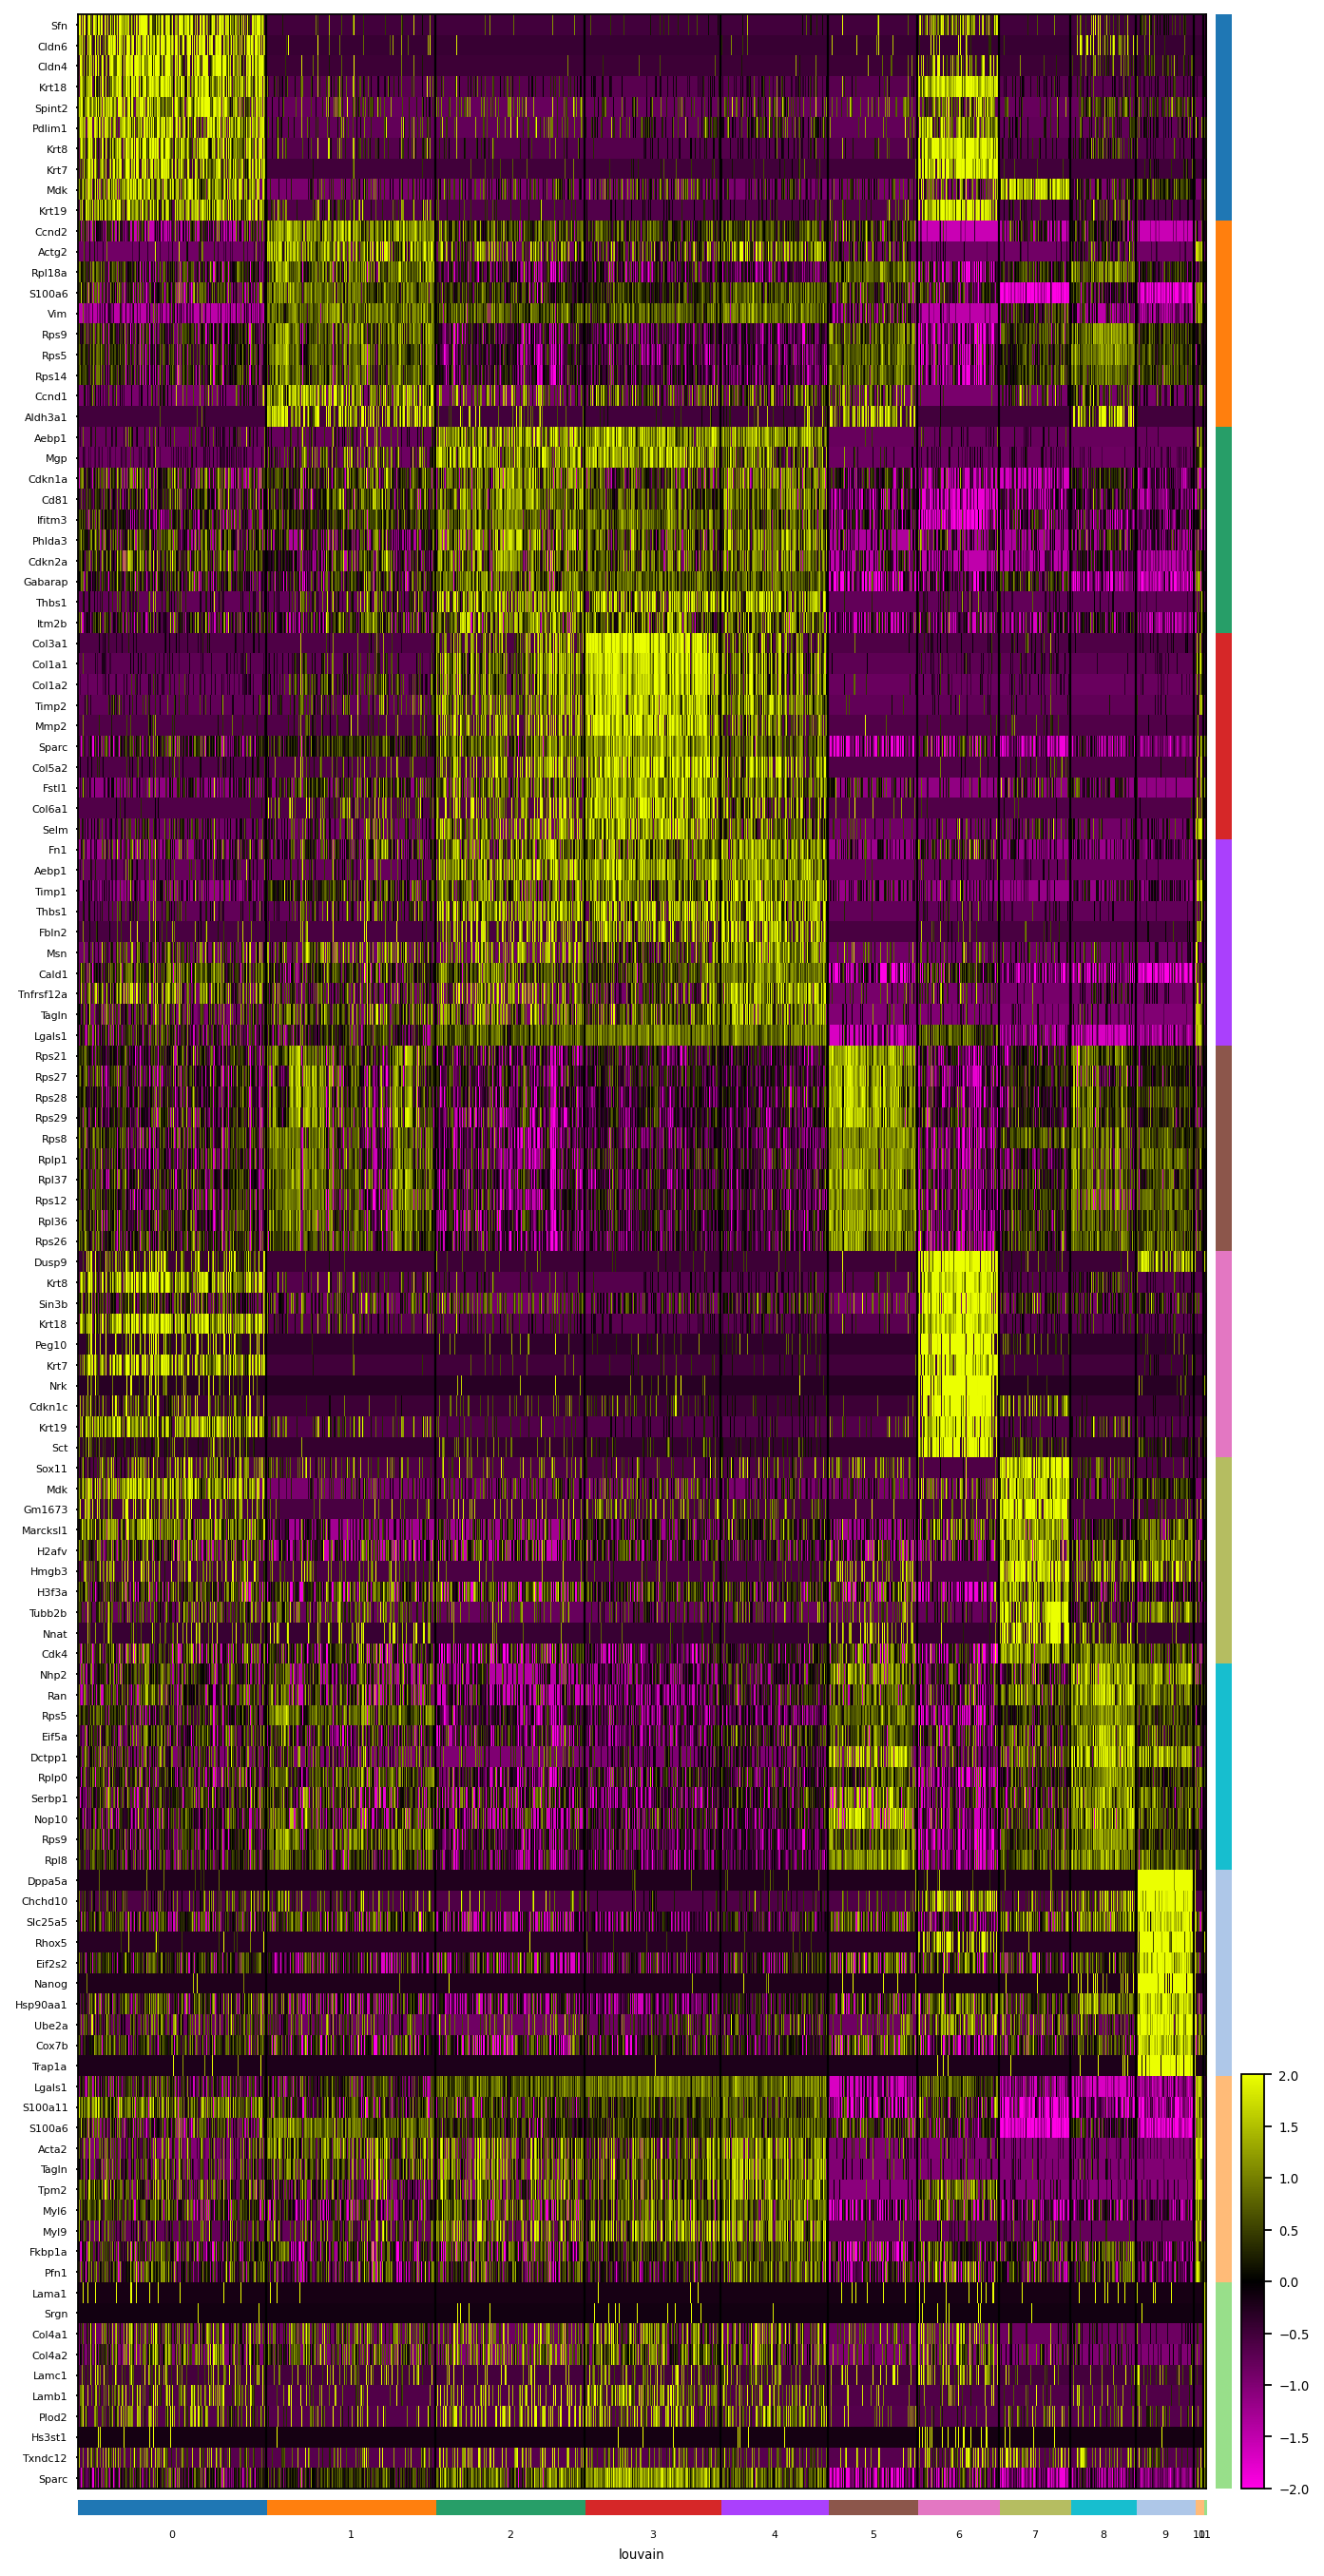

In [70]:
n_genes = 10
n_clusters = np.unique(adata_deg.obs['louvain']).shape[0]
marker_genes_dict = {'{}'.format(i): 
                     [adata_deg.uns['rank_genes_groups']['names'][j][i] for j in range(n_genes)] for i in range(n_clusters)}

sc.set_figure_params(dpi_save=300, frameon=False, facecolor='white', fontsize=6)
sc.pl.heatmap(adata_deg, marker_genes_dict, groupby='louvain', 
               cmap=mpl.colors.LinearSegmentedColormap.from_list('custom', ['#FF00E5', '#000000', '#EBFF00'], N=256), 
               dendrogram=False, layer='scaled', vmin=-2, vmax=2, 
               show_gene_labels=True, swap_axes=True, save='_reprogramming_DEG.png')

N = len(adata_deg.uns['rank_genes_groups']['names'])
K = len(adata_deg.uns['rank_genes_groups']['names'][0])

names = {i: np.expand_dims([adata_deg.uns['rank_genes_groups']['names'][j][i] for j in range(N)], axis=1) for i in range(K)}
scores = {i: np.expand_dims([adata_deg.uns['rank_genes_groups']['scores'][j][i] for j in range(N)], axis=1) for i in range(K)}

pd.DataFrame(np.concatenate([np.concatenate([names[i], scores[i]], axis=1) for i in range(K)], axis=1), 
             columns=np.concatenate([['cluster {} gene'.format(i), 'cluster {} score'.format(i)] for i in range(K)])
            ).to_csv('reprogramming_DEG.csv', index=False)